In [1]:
import pandas as pd 
import numpy as np 
import pathlib as path
import matplotlib.pyplot as plt
import random
from PIL import Image
from random import sample
import statsmodels.api as sm
import os
from scipy.stats import binomtest

In [2]:
#define the relevant path to the current batch you wish to parse
project_name='multicategory_working_memory'
experiment_name='experiment 1'
qualification_method='loose' #or 'loose' or #'none' (will take the entire sample of participants that we have values for)

add_similarity_values=False #this adds the similarity of each image pair in the actuall experiment it takes some time (15 minutes)

model_name='VGG' #the only model we work with atm so dont change
PATH_TO_BATCH=path.Path.cwd().parent.parent.parent / 'projects' / project_name / experiment_name / 'collected data' 
PATH_TO_PROJECT=path.Path.cwd().parent.parent.parent / 'projects' / project_name 
PATH_TO_EXPERIMENT=path.Path.cwd().parent.parent.parent / 'projects' / project_name / experiment_name
PATH_TO_OUTPUTS=path.Path.cwd().parent.parent.parent / 'projects' / project_name / experiment_name / 'figures and outputs' 
if PATH_TO_BATCH.exists():
    print('batch folder found at:\n' ,PATH_TO_BATCH)
else: 
    print('path to batch is non existent:\n',PATH_TO_BATCH)

batch folder found at:
 /Users/edenzohar/Thesis/visual_memory_representation_final/projects/multicategory_working_memory/experiment 1/collected data


In [3]:
all_directories_paths = [x[0] for x in os.walk(PATH_TO_BATCH) if 'batch' in x[0].split('\\')[-1] ]

#delete the following rows once batch 2 is actually filled with data and processed. 
all_directories_paths = all_directories_paths[0::2]

In [4]:

if qualification_method=='none':
    filename = 'one_line_per_participant_all_info_all_subject_strict.csv' #note that why i do use the "strict" its irrelevant as all_subjects includes all of th em and not just qualified so criterion is irrelevant for this line
elif qualification_method in ['strict','loose']:
    filename = 'one_line_per_participant_all_info_valid_subjects_only_'+qualification_method+'.csv'
else: 
    raise Exception(f'the qualification method choosen {qualification_method} is invalid')

all_valid_subjects = pd.DataFrame([])
for batch in all_directories_paths:
    time_gap = path.Path(batch).parent.name
    PATH_PROCESED = batch/path.Path(filename)
    file = pd.read_csv(PATH_PROCESED,index_col=0)
    file['time_gap'] = time_gap
    file['worker_ID'] = file.index 
    file['batch_number'] = int(path.Path(batch).name.split(' ')[-1])
    
    all_valid_subjects = pd.concat([all_valid_subjects,file])

In [27]:
print(f'there are {len(all_valid_subjects.index) - len(set(all_valid_subjects.index))}, duplicate subjects')

there are 0, duplicate subjects


In [29]:
def add_connecting_lines_to_stripplot(stripplot_handle,ax):
  #get the current offsets:
  paths = stripplot_handle.collections
  #get x offsets:
  x_offsets = [path.get_offsets()[:,0] for path in paths]
  x_offsets_arrays=[np.array(offsets) for offsets in x_offsets]
  #get y offsets:
  y_offsets = [path.get_offsets()[:,1] for path in paths]
  y_offsets_arrays=[np.array(offsets) for offsets in y_offsets]
  # Connect each pair of points from the same row with a line
  for bar_ind in np.arange(0,len(x_offsets_arrays)-1):
    for i in range(len(x_offsets_arrays[0])):
      ax.plot([x_offsets_arrays[bar_ind][i], x_offsets_arrays[bar_ind+1][i]], [y_offsets_arrays[bar_ind][i], y_offsets_arrays[bar_ind+1][i]], color="gray", alpha=0.75)

/Users/edenzohar/Thesis/visual_memory_representation_final/.venv/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)
/Users/edenzohar/Thesis/visual_memory_representation_final/.venv/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


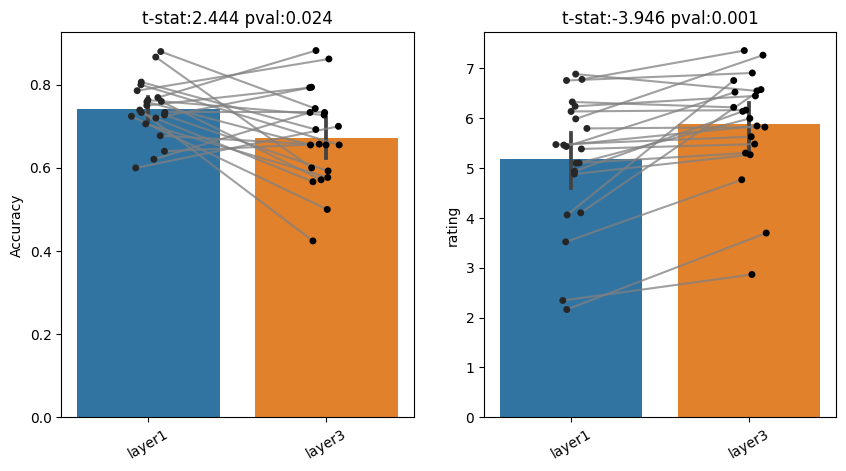

In [30]:
import scipy.stats as stats
import seaborn as sns


d1 = all_valid_subjects['level_1_accuracy']
d2 = all_valid_subjects['level_3_accuracy']
t_stat, p_value = stats.ttest_rel(d1, d2)


fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.barplot(data=all_valid_subjects[['level_1_accuracy','level_3_accuracy']],ax=axes[0])
handel1 = sns.stripplot(data=all_valid_subjects[['level_1_accuracy','level_3_accuracy']],ax=axes[0],color='k')

axes[0].set_xticklabels(labels=['layer1','layer3'],rotation=30)
axes[0].set_ylabel('Accuracy')
axes[0].set_title(f't-stat:{t_stat:.3f} pval:{p_value:.3f}')

sns.barplot(data=all_valid_subjects[['level_1_rating','level_3_rating']],ax = axes[1])
handel2 = sns.stripplot(data=all_valid_subjects[['level_1_rating','level_3_rating']],color='k',ax = axes[1])


d1 = all_valid_subjects['level_1_rating']
d2 = all_valid_subjects['level_3_rating']
t_stat, p_value = stats.ttest_rel(d1, d2)

axes[1].set_xticklabels(labels=['layer1','layer3'],rotation=30)
axes[1].set_ylabel('rating')
axes[1].set_title(f't-stat:{t_stat:.3f} pval:{p_value:.3f}')


add_connecting_lines_to_stripplot(handel1,axes[0])
add_connecting_lines_to_stripplot(handel2,axes[1])

In [32]:
all_valid_subjects['worker_ID'] = all_valid_subjects.index
rt_df = pd.melt(all_valid_subjects,id_vars=['worker_ID'],value_vars=['level_1_rt','level_3_rt'],var_name='layer')
accuracy_df = pd.melt(all_valid_subjects,id_vars=['worker_ID'],value_vars=['level_1_accuracy','level_3_accuracy'],var_name='layer')

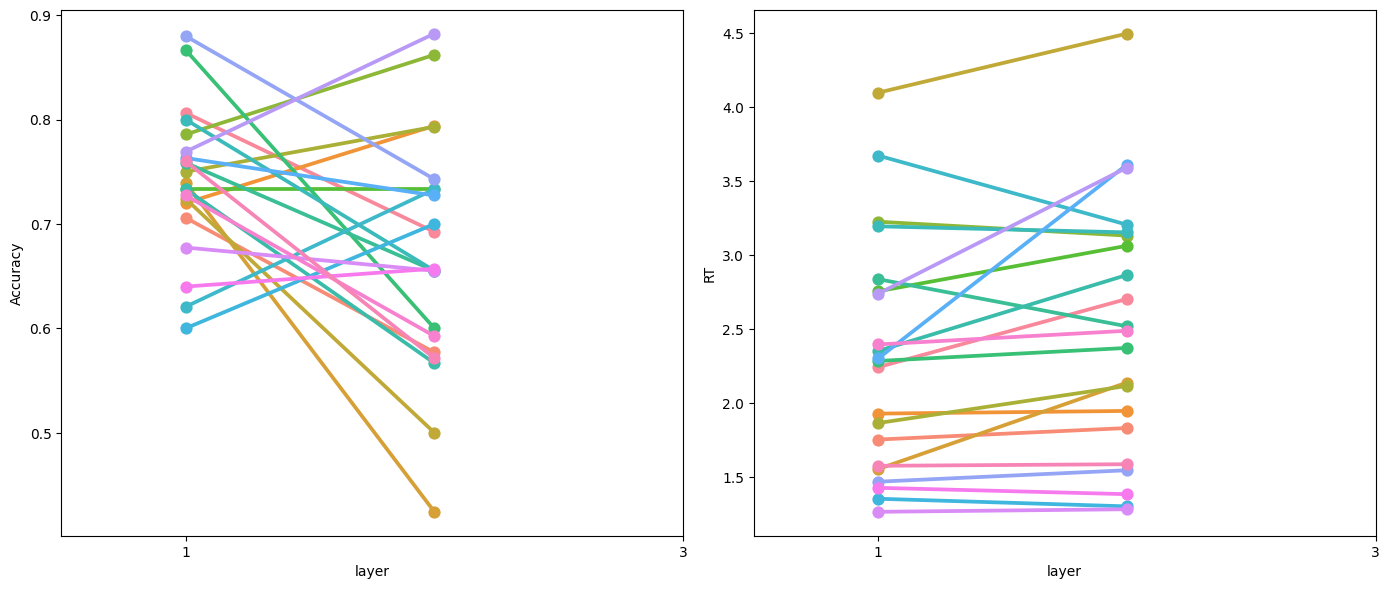

In [34]:
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(14,6),sharex=True,sharey=False)
#accuracy: 
G = sns.pointplot(data=accuracy_df,x='layer', y='value', hue='worker_ID', ax=axes[0])
plt.xticks([0,2],['1','3'])
axes[0].set_ylabel('Accuracy')
axes[0].get_legend().remove() 

#rt: 
sns.pointplot(data=rt_df,x='layer', y='value', hue='worker_ID', ax=axes[1])
plt.xticks([0,2],['1','3'])
plt.ylabel('RT')
axes[1].get_legend().remove() 
plt.tight_layout()

## concatanate the working memory data with the same day and 24 hours data

In [27]:
PATH_TO_NON_WORKING_MEMORY_TIME_GAPS =path.Path.cwd().parent.parent.parent / 'projects' / 'multicategory' / 'experiment 1' 


all_directories_paths = [x[0] for x in os.walk(PATH_TO_NON_WORKING_MEMORY_TIME_GAPS) if ('batch' in x[0].split('\\')[-1]) and ('data'  not in x[0].split('/')[-1])]


all_directories_paths


['/Users/edenzohar/Thesis/visual_memory_representation_final/projects/multicategory/experiment 1/collected data/pilot_same_day/batch 1',
 '/Users/edenzohar/Thesis/visual_memory_representation_final/projects/multicategory/experiment 1/collected data/pilot_same_day/batch 2',
 '/Users/edenzohar/Thesis/visual_memory_representation_final/projects/multicategory/experiment 1/collected data/pilot_24_hours/batch 1',
 '/Users/edenzohar/Thesis/visual_memory_representation_final/projects/multicategory/experiment 1/collected data/pilot_24_hours/batch 3',
 '/Users/edenzohar/Thesis/visual_memory_representation_final/projects/multicategory/experiment 1/collected data/pilot_24_hours/batch 2']